# Pareto Front: Assess All Feasible Solutions for a Patient

For a given patient, generate all feasible surgical plans and score them using both:
- Mechanical Failure Risk Model
- Composite Score Model

## Setup and Load Models

In [8]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

import numpy as np
import pandas as pd
import joblib

import src.optimization_utils as ou
from src import config

# Load models
bundle_mech_fail = joblib.load("../artifacts/mech_fail_xgb.joblib")
bundle_composite = joblib.load("../artifacts/composite_score_model.joblib")

print("Mechanical Failure Model:", bundle_mech_fail["model_name"])
print("Composite Score Model:", bundle_composite["model_name"])
print()
print(f"Mech Fail Features ({len(bundle_mech_fail['features'])}): {bundle_mech_fail['features']}")
print(f"Composite Features ({len(bundle_composite['features'])}): {bundle_composite['features']}")

Mechanical Failure Model: mech_fail_xgb
Composite Score Model: composite_histgb_reg

Mech Fail Features (23): ['age', 'sex', 'PI_preop', 'PT_preop', 'LL_preop', 'SS_preop', 'T4PA_preop', 'L1PA_preop', 'SVA_preop', 'cobb_main_curve_preop', 'FC_preop', 'tscore_femneck_preop', 'HU_UIV_preop', 'HU_UIVplus1_preop', 'HU_UIVplus2_preop', 'UIV_implant', 'num_interbody_fusion_levels', 'ALIF', 'XLIF', 'TLIF', 'num_rods', 'num_pelvic_screws', 'osteotomy']
Composite Features (23): ['age', 'sex', 'PI_preop', 'PT_preop', 'LL_preop', 'SS_preop', 'T4PA_preop', 'L1PA_preop', 'SVA_preop', 'cobb_main_curve_preop', 'FC_preop', 'tscore_femneck_preop', 'HU_UIV_preop', 'HU_UIVplus1_preop', 'HU_UIVplus2_preop', 'UIV_implant', 'num_interbody_fusion_levels', 'ALIF', 'XLIF', 'TLIF', 'num_rods', 'num_pelvic_screws', 'osteotomy']


## Get Decision Space (Feasible Solutions)

In [ ]:
# Get decision variable bounds and UIV choices
UIV_CHOICES, xl, xu = ou.get_decision_config()

print("Decision Variable Bounds:")
print(pd.DataFrame([xl, xu], index=["lower_bound","upper_bound"], columns=config.PLAN_COLS))

Decision Variable Bounds:
             uiv_code  num_levels  ALIF  XLIF  TLIF  num_rods  \
lower_bound         0           0     0     0     0         1   
upper_bound         2           5     1     1     1         6   

             num_pelvic_screws  osteotomy  
lower_bound                  1          0  
upper_bound                  6          1  


## Select a Patient

In [ ]:
df = pd.read_csv(config.DATA_INTERMEDIATE)
df.columns = df.columns.astype(str).str.replace("\n"," ").str.replace(r"\s+"," ", regex=True).str.strip()

print(f"Loaded {len(df)} patients")
print(f"Predictors ({len(config.PREDICTORS)}): {config.PREDICTORS}")

Loaded 277 patients
Predictors (15): ['age', 'sex', 'PI_preop', 'PT_preop', 'LL_preop', 'SS_preop', 'T4PA_preop', 'L1PA_preop', 'SVA_preop', 'cobb_main_curve_preop', 'FC_preop', 'tscore_femneck_preop', 'HU_UIV_preop', 'HU_UIVplus1_preop', 'HU_UIVplus2_preop']


In [11]:
# Select patient by index
patient_idx = 2

if patient_idx < 0 or patient_idx >= len(df):
    print(f"Error: patient_idx {patient_idx} out of range (0-{len(df)-1})")
else:
    patient_row = df.iloc[patient_idx]
    patient_fixed = patient_row[config.PREDICTORS].to_dict()
    print(f"Patient Index: {patient_idx}")
    print(f"Patient Demographics (Predictors):")
    for k, v in patient_fixed.items():
        print(f"  {k}: {v}")


Patient Index: 2
Patient Demographics (Predictors):
  age: 82
  sex: FEMALE
  PI_preop: 37.5
  PT_preop: 22.0
  LL_preop: 13.0
  SS_preop: 15.5
  T4PA_preop: 23.6
  L1PA_preop: 5.8
  SVA_preop: 136.5
  cobb_main_curve_preop: 16.2
  FC_preop: 12.0
  tscore_femneck_preop: nan
  HU_UIV_preop: 138.0
  HU_UIVplus1_preop: 137.0
  HU_UIVplus2_preop: 136.0


## Generate All Feasible Solutions

In [ ]:
from itertools import product

ranges = [range(int(xl[i]), int(xu[i]) + 1) for i in range(len(xl))]
solutions = np.array([np.array(combo) for combo in product(*ranges)])

range_sizes = [len(r) for r in ranges]
total_combos = 1
for size in range_sizes:
    total_combos *= size

print("Decision Variable Ranges:")
for i, (name, size) in enumerate(zip(config.PLAN_COLS, range_sizes)):
    print(f"  {name}: {range_sizes[i]} options")

print(f"\nTotal combinations: {' × '.join(map(str, range_sizes))} = {total_combos}")
print(f"Total feasible solutions: {len(solutions)}")
print(f"Sample first 5 solutions:\n{solutions[:5]}")

Decision Variable Ranges:
  uiv_code: 3 options
  num_levels: 6 options
  ALIF: 2 options
  XLIF: 2 options
  TLIF: 2 options
  num_rods: 6 options
  num_pelvic_screws: 6 options
  osteotomy: 2 options

Total combinations: 3 × 6 × 2 × 2 × 2 × 6 × 6 × 2 = 10368
Total feasible solutions: 10368
Sample first 5 solutions:
[[0 0 0 0 0 1 1 0]
 [0 0 0 0 0 1 1 1]
 [0 0 0 0 0 1 2 0]
 [0 0 0 0 0 1 2 1]
 [0 0 0 0 0 1 3 0]]


## Score All Solutions with Both Models

In [ ]:
def score_solution(x, patient_fixed, bundle_mech, bundle_comp, uiv_choices):
    plan = ou.decode_plan(x, uiv_choices)
    features_dict = {**patient_fixed, **plan}
    
    mech_fail_features = bundle_mech["features"]
    X_mech = pd.DataFrame([{c: features_dict.get(c, np.nan) for c in mech_fail_features}])
    mech_fail_risk = float(bundle_mech["pipe"].predict_proba(X_mech)[:, 1][0])
    
    comp_features = bundle_comp["features"]
    X_comp = pd.DataFrame([{c: features_dict.get(c, np.nan) for c in comp_features}])
    composite_score = float(bundle_comp["pipe"].predict(X_comp)[0])
    
    return mech_fail_risk, composite_score, plan

results = []
for i, x in enumerate(solutions):
    if i % 100 == 0:
        print(f"Scoring solution {i}/{len(solutions)}...")
    try:
        mech_risk, comp_score, plan = score_solution(x, patient_fixed, bundle_mech_fail, bundle_composite, UIV_CHOICES)
        result_row = {
            "uiv_code": int(x[0]),
            "num_interbody_fusion_levels": int(x[1]),
            "ALIF": int(x[2]),
            "XLIF": int(x[3]),
            "TLIF": int(x[4]),
            "num_rods": int(x[5]),
            "num_pelvic_screws": int(x[6]),
            "osteotomy": int(x[7]),
            "UIV_implant": plan.get("UIV_implant"),
            "mech_fail_risk": mech_risk,
            "composite_score": comp_score,
        }
        results.append(result_row)
    except Exception as e:
        print(f"  Error at solution {i}: {e}")

df_results = pd.DataFrame(results)
print(f"\nSuccessfully scored {len(df_results)} solutions")
print(f"\nResults summary:")
print(df_results[["mech_fail_risk", "composite_score"]].describe())

Scoring solution 0/10368...
Scoring solution 100/10368...


## Identify Pareto Front

In [ ]:
# A solution is on the Pareto front if:
# - We can't find another solution with BOTH lower risk AND lower composite score

def is_pareto_optimal(idx, risks, scores):
    my_risk = risks[idx]
    my_score = scores[idx]
    for i in range(len(risks)):
        if i != idx and risks[i] < my_risk and scores[i] < my_score:
            return False
    return True

risks = df_results["mech_fail_risk"].values
scores = df_results["composite_score"].values
pareto_mask = [is_pareto_optimal(i, risks, scores) for i in range(len(df_results))]
df_pareto = df_results[pareto_mask].copy().reset_index(drop=True)

print(f"Pareto front solutions: {len(df_pareto)} out of {len(df_results)}")
print(f"\nPareto front (sorted by composite score, lowest first):")
print(df_pareto[config.PLAN_COLS + ["UIV_implant", "mech_fail_risk", "composite_score"]].sort_values("composite_score", ascending=True))

Pareto front solutions: 592 out of 10368

Pareto front (sorted by composite score):
     uiv_code  num_interbody_fusion_levels  ALIF  XLIF  TLIF  num_rods  \
0           1                            0     0     0     0         1   
161         1                            1     0     1     1         1   
28          1                            0     0     0     1         3   
30          1                            0     0     0     1         3   
92          1                            1     0     0     0         1   
..        ...                          ...   ...   ...   ...       ...   
418         1                            5     0     1     0         4   
416         1                            5     0     1     0         4   
410         1                            5     0     0     1         6   
408         1                            5     0     0     1         6   
296         1                            4     0     1     0         4   

     num_pelvic_screws  ost

## Visualize Pareto Front

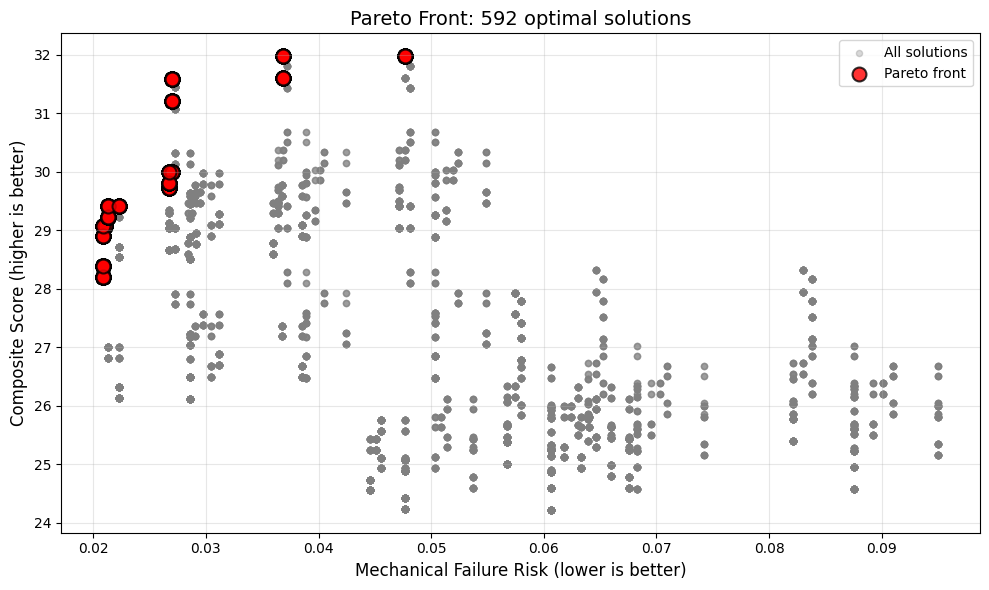

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df_results["mech_fail_risk"], df_results["composite_score"], 
          alpha=0.3, s=20, label="All solutions", color="gray")

# Plot Pareto front
ax.scatter(df_pareto["mech_fail_risk"], df_pareto["composite_score"], 
          alpha=0.8, s=100, label="Pareto front", color="red", edgecolors="black", linewidth=1.5)

ax.set_xlabel("Mechanical Failure Risk (lower is better)", fontsize=12)
ax.set_ylabel("Composite Score (lower is better)", fontsize=12)
ax.set_title(f"Pareto Front: {len(df_pareto)} optimal solutions", fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
print("\n" + "=" * 120)
print("BEST UNIQUE PARETO-OPTIMAL PLANS (sorted by composite score)")
print("=" * 120)

# Remove exact duplicates and display the unique plans
df_unique = df_pareto.drop_duplicates(subset=config.PLAN_COLS, keep="first").reset_index(drop=True)
df_unique_sorted = df_unique.sort_values("composite_score", ascending=True)

print(f"\n{len(df_unique_sorted)} unique plans:\n")
for idx, row in df_unique_sorted.iterrows():
    print(f"Plan {idx + 1}:")
    print(f"  UIV Implant: {row['UIV_implant']}")
    print(f"  Interbody Fusion Levels: {int(row['num_interbody_fusion_levels'])}")
    print(f"  ALIF: {int(row['ALIF'])}, XLIF: {int(row['XLIF'])}, TLIF: {int(row['TLIF'])}")
    print(f"  Rods: {int(row['num_rods'])}, Pelvic Screws: {int(row['num_pelvic_screws'])}, Osteotomy: {int(row['osteotomy'])}")
    print(f"  → Mech Failure Risk: {row['mech_fail_risk']:.4f}")
    print(f"  → Composite Score: {row['composite_score']:.4f}")
    print()


BEST UNIQUE PARETO-OPTIMAL PLANS (sorted by composite score)


NameError: name 'df_pareto' is not defined

In [ ]:
import matplotlib.pyplot as plt

# Zoomed-out view with all solutions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: All solutions with Pareto front highlighted
ax = axes[0]
ax.scatter(df_results["mech_fail_risk"], df_results["composite_score"], 
          alpha=0.2, s=30, label="All solutions", color="gray")
ax.scatter(df_pareto["mech_fail_risk"], df_pareto["composite_score"], 
          alpha=0.7, s=80, label=f"Pareto front ({len(df_pareto)} solutions)", color="red", edgecolors="darkred", linewidth=1)

ax.set_xlabel("Mechanical Failure Risk (lower is better)", fontsize=11)
ax.set_ylabel("Composite Score (lower is better)", fontsize=11)
ax.set_title("Zoomed-out View: Full Solution Space", fontsize=12, fontweight="bold")
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Right plot: Unique Pareto solutions only
ax = axes[1]
ax.scatter(df_pareto["mech_fail_risk"], df_pareto["composite_score"], 
          alpha=0.3, s=50, label="All Pareto solutions", color="lightcoral")
ax.scatter(df_unique_sorted["mech_fail_risk"], df_unique_sorted["composite_score"], 
          alpha=0.9, s=120, label=f"Unique plans ({len(df_unique_sorted)} plans)", color="darkred", edgecolors="black", linewidth=1.5)

# Connect points to show trade-off
ax.plot(df_unique_sorted.sort_values("mech_fail_risk")["mech_fail_risk"], 
        df_unique_sorted.sort_values("mech_fail_risk")["composite_score"],
        'k--', alpha=0.3, linewidth=1, label="Trade-off curve")

ax.set_xlabel("Mechanical Failure Risk (lower is better)", fontsize=11)
ax.set_ylabel("Composite Score (lower is better)", fontsize=11)
ax.set_title("Zoomed-out View: Unique Optimal Plans", fontsize=12, fontweight="bold")
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Patient Post-op Results


In [ ]:
print(f"Patient {patient_idx} - Gap Score Pre-op vs Post-op:")
print("=" * 60)
print(f"{'Measurement':<25} {'Pre-op':<15} {'Post-op':<15}")
print("-" * 60)

gap_score_preop = df.iloc[patient_idx]['gap_score_preop']
gap_score_postop = df.iloc[patient_idx]['gap_score_postop']
print(f"{'Gap Score':<25}", end="")
print(f"{str(gap_score_preop):<15}", end="")
print(f"{str(gap_score_postop):<15}")

gap_cat_preop = df.iloc[patient_idx]['gap_category']
gap_cat_postop = df.iloc[patient_idx]['gap_category_postop']
print(f"{'Gap Category':<25}", end="")
print(f"{str(gap_cat_preop):<15}", end="")
print(f"{str(gap_cat_postop):<15}")

Patient 2 - Gap Score Pre-op vs Post-op:
Measurement               Pre-op          Post-op        
------------------------------------------------------------
Gap Score                13             9.0            
Gap Category             SD             SD             
